### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File 'RGBNIR_DSM_CHM_VIf_v4.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr
```
- last commands will install julia libraries, necessary to run the notebook.

### Running PySR 

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
import skill_metrics as sm
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

### Set up PySR run:


using Moises' data

In [3]:
df = pd.read_csv('RGBNIR_DSM_CHM_VIf_v4.csv')
# print(df.head())
X = df.iloc[:,1:-3]
y = df.LAI
print(X.head())

        Red     Green      Blue       NIR        FC       ch1        CH  \
0  0.020630  0.030237  0.003344  0.219818  0.680556  2.275999  2.451676   
1  0.020253  0.030407  0.003233  0.223823  0.652778  2.180176  2.469830   
2  0.022048  0.030032  0.003725  0.210354  0.598958  2.232824  2.363652   
3  0.022679  0.030747  0.003710  0.220522  0.500000  1.980601  2.298613   
4  0.023883  0.028469  0.003943  0.198092  0.522569  2.300652  2.226254   

         wc        WC      geom  ...     RGBVI      RGRI       RI4XS  \
0  1.076450  0.999317  5.576198  ...  0.859666  0.682277  509.138228   
1  1.077895  0.951482  5.123413  ...  0.867741  0.666062  479.839566   
2  0.965705  0.912254  4.814528  ...  0.833071  0.734158  597.604433   
3  0.908815  0.783081  3.565081  ...  0.836553  0.737611  575.514103   
4  0.817703  0.845029  4.328101  ...  0.791812  0.838918  868.336743   

         SI         SR      TDVI       TGI       TVI      TriVI      VARI  
0  0.981867  10.655179  0.396112  1.9498

The default parameters will help speed up code and ensure repeteability of run

In [4]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= "L2DistLoss()",  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [5]:
# Learn equations
model = PySRRegressor(
    niterations=100,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=3600*2,  # this line will make the code stop after 2 hours
    binary_operators=["+", "*","-","/"], # these are the default binary operators
    # unary_operators=["sqrt", "exp", "log", "inv", "special(x, y) = ((x - y)/(x + y))"], # other basic operators can be added here
    # extra_sympy_mappings={"inv": lambda x: 1 / x, "special": lambda x, y: (x - y)/(x + y)}, # here we can add custom functions
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)

c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\pysr\sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          2.3271852   
	1         0.344156                                    3.3589559 / ch1   
	2         0.161917                             (wc - ch1) + 2.6554635   
	3         0.076803                    (2.7923734 - ch1) * (WC + RGRI)   
	4         0.009038          GRNDVI + ((EVI2 + WC) * (2.588882 - ch1))   
	5         0.018252  ((2.6889687 - ch1) * ((WC + TDVI) + NDTI)) + G...   
	6         0.010229  ((2.3932076 - ch1) * ((4.4488325 - wc) * (WC *...   
	7         0.065885  ((((WC * (3.6705446 - wc)) + TDVI) - ch1) * (2...   
	8         0.017599  ((TDVI + ((WC * ((4.135313 - wc) * 0.70668274)...   
	9         0.007448  (((((WC * 0.73400885) * (4.0884614 - wc)) + (T...   
	10        0.004055  (((((WC * 0.722412) * (4.0698543 - wc)) + (TDV...   
	11        0.007064  (GNDVI + (((TDVI - ch1) + ((-2.6321473 / NDDI)...   
	12  >>>>  0.077136  (((2.4647894 * (WC - RGBVI)) + (2.16512 - ch1)...   
	13        0.005602  1.2583879 + (((2.1856496 - ch1) + ((BNDVI * (W...   
	14        0.000259  (((BNDVI * 1.9083945) + (((NLI * 1.2788956) - ...   
	15        0.000580  ((((BNDVI * 1.908308) + ((NLI * 1.2553579) - c...   
	16        0.000731  ((((((NLI * 1.2932851) - ch1) + (BNDVI * 1.899...   
	17        0.002543  (BNDVI * ((((((WC - RGBVI) * (NDYI + 1.1901473...   
	18        0.009031  (((geom / NDDI) + ch1) + -0.71675014) + (((BND...   
	19        0.007563  (((((((((TDVI + TVI) - 2.2375782) + 2.570586) ...   
	20        0.001029  (BNDVI * (((((RGBVI + 1.0953913) * (WC - RGBVI...   
	21        0.000698  (BNDVI * (((((RGBVI + 1.1055236) * (WC - RGBVI...   
	
	        loss  complexity  
	0   1.315314           1  
	1   0.660845           3  
	2   0.478036           5  
	3   0.409968           7  
	4   0.402624           9  
	5   0.388192          11  
	6   0.380331          13  
	7   0.333376          15  
	8   0.321847          17  
	9   0.317088          19  
	10  0.314527          21  
	11  0.310114          23  
	12  0.265780          25  
	13  0.259891          29  
	14  0.259756          31  
	15  0.259455          33  
	16  0.259076          35  
	17  0.257762          37  
	18  0.253148          39  
	19  0.249348          41  
	20  0.248324          45  
	21  0.247977          47  
]

We can print the model pareto curve, which will showcase the trend of discovered solutions:

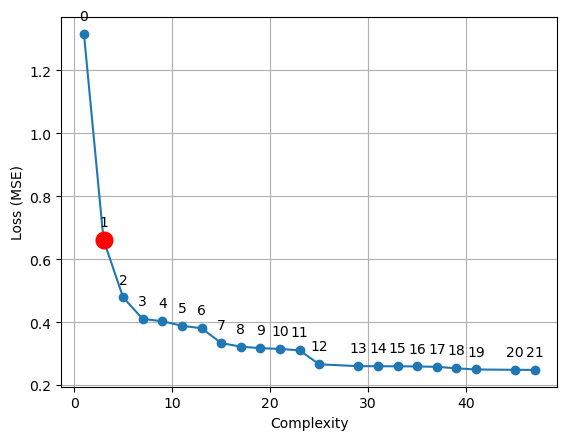

In [6]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
max_index = scores.idxmax(axis=0)
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [7]:
model.sympy(7)  # get the 7th equation in sympy format

(2.3729188 - ch1)*(TDVI + WC*(3.6705446 - wc) - ch1) - 1*(-0.96003306)

In this run, Eq 1 was the best, so:

In [8]:
model.sympy(1)

3.3589559/ch1

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [9]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.315314,2.3271852
1,0.660845,3.3589559 / ch1
2,0.478036,(wc - ch1) + 2.6554635
3,0.409968,(2.7923734 - ch1) * (WC + RGRI)
4,0.402624,GRNDVI + ((EVI2 + WC) * (2.588882 - ch1))
5,0.388192,((2.6889687 - ch1) * ((WC + TDVI) + NDTI)) + GRNDVI
6,0.380331,((2.3932076 - ch1) * ((4.4488325 - wc) * (WC * 0.65691936))) - -0.55711263
7,0.333376,((((WC * (3.6705446 - wc)) + TDVI) - ch1) * (2.3729188 - ch1)) - -0.96003306
8,0.321847,((TDVI + ((WC * ((4.135313 - wc) * 0.70668274)) - ch1)) * (2.5084913 - ch1)) - -1.0782533
9,0.317088,(((((WC * 0.73400885) * (4.0884614 - wc)) + (TDVI - ch1)) * (2.4578443 - ch1)) - -0.36552814) + GNDVI


## Output

Plotting the first solutions

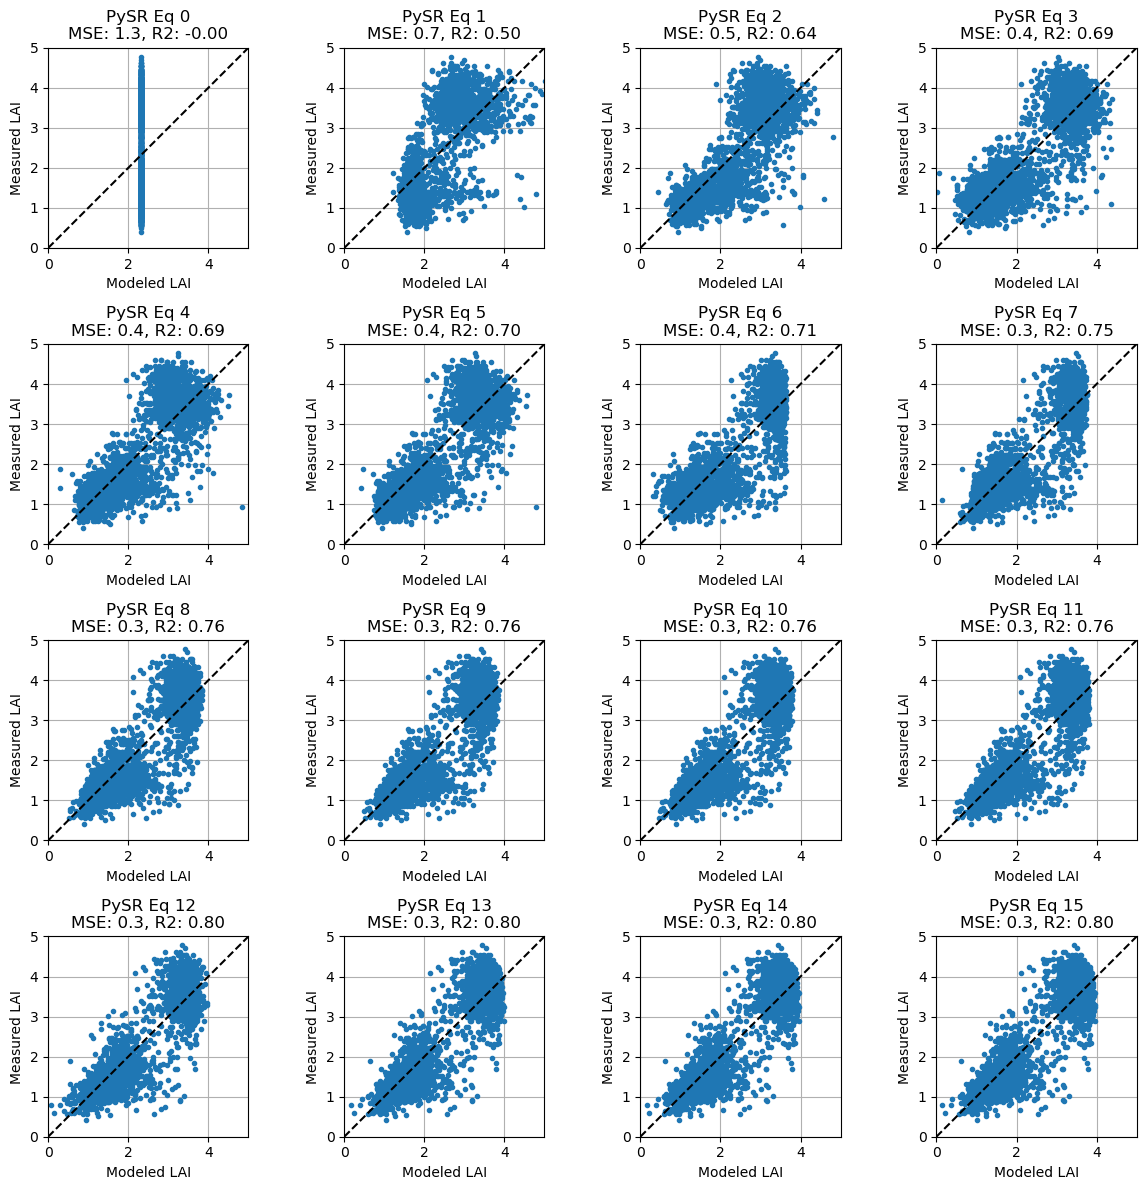

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

it = np.linspace(0,15,16, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(ypredict_simpler, y,'.')
    ax.grid(True)
    ax.set_xlabel("Modeled LAI")
    ax.set_ylabel("Measured LAI")
    ax.plot( [0,5], [0,5], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    mse =np.power(ypredict_simpler - y, 2).mean()
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



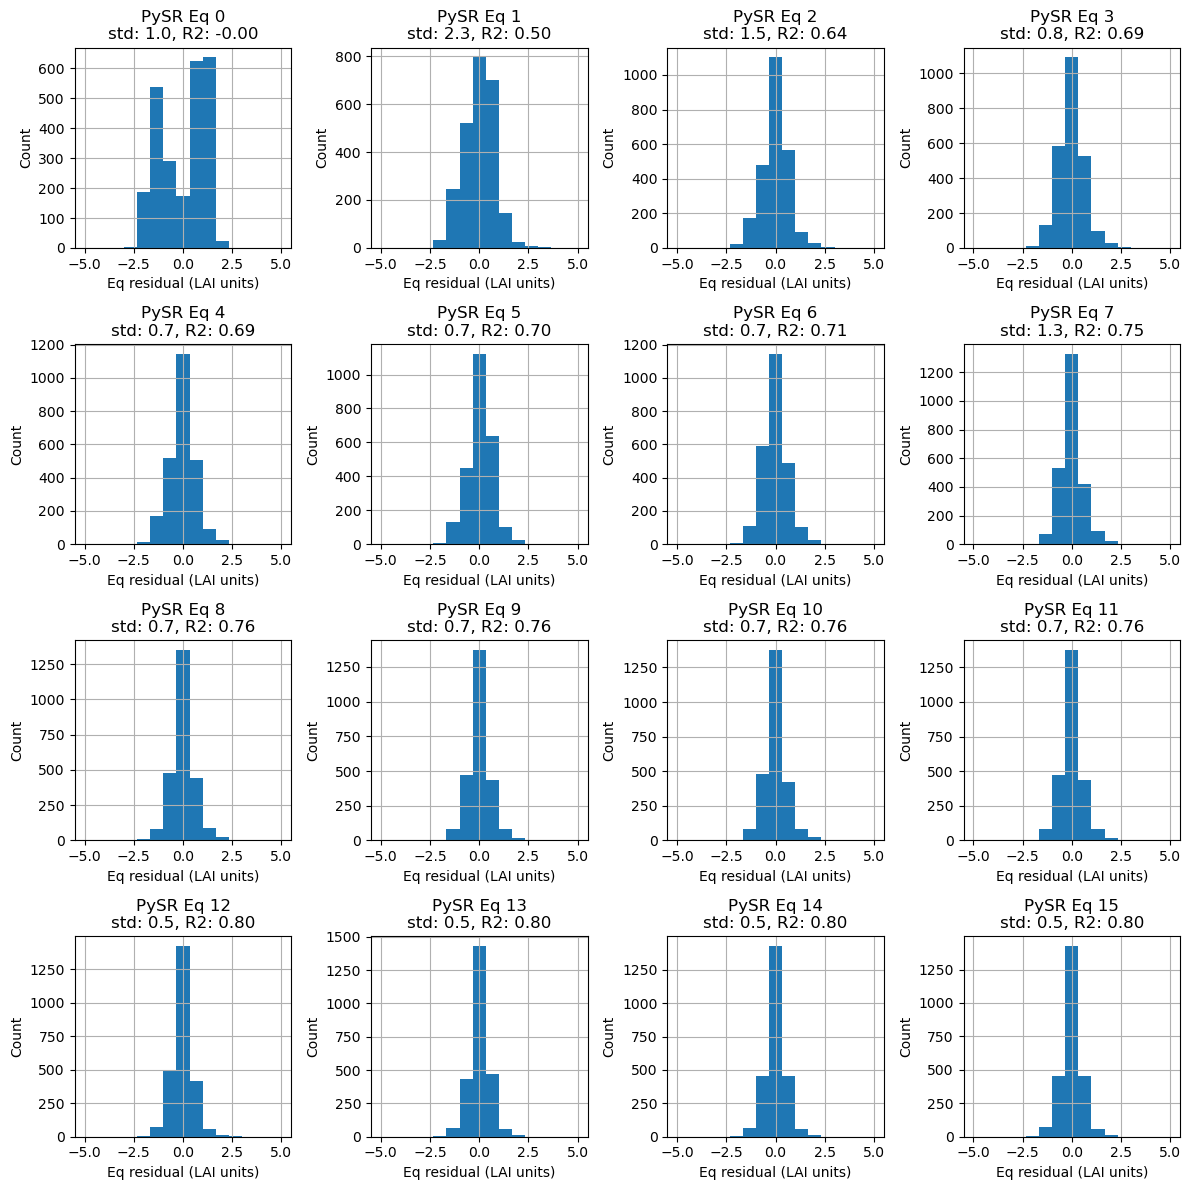

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

it = np.linspace(0,15,16, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y,range=(-5,5), bins=15)
    ax.grid(True)
    ax.set_xlabel("Eq residual (LAI units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )

    # ax.set_aspect('equal')
    # ax.set_xlim(0, 70)
    # ax.set_ylim(0, 70)
    std =np.std(np.power(ypredict_simpler - y, 2)).mean()
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Create a Taylor diagram with labeled data points and modified axes

c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


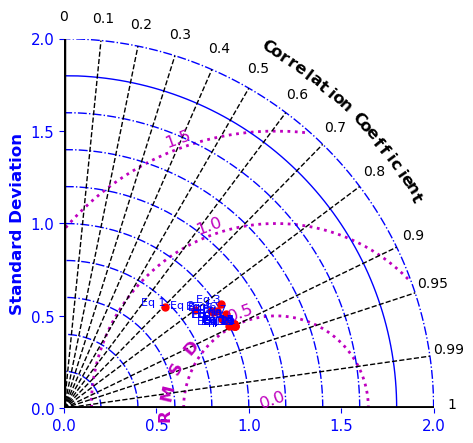

In [20]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api